In [1]:
import numpy as np
import scipy
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt
import h5py
import progressbar

from HelperAndMechanics import *
from scipy.ndimage import gaussian_filter1d
import jax.numpy as jnp
from jax import jit

In [2]:
N = 15000
# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta_var_l.h5', 'r') as f:
    x_temp = f['x_temp'][:]
    x_cm_temp = f['x_cm_temp'][:]
    T = f['T'][:]
    dA = f['dA'][:]
    f.close()
#normalize each point
x_temp = x_temp-x_cm_temp[0,:,:,:]

In [ ]:
def euclidean_distance_trajectory(x_arr_fit_flattened, x_arr_train_flattened,y_train):
    '''calculate the euclidean distance between the fit and training data. choses shorfit eucledean distance
    shape input 
    x_arr_fit_flattened: (Dim_x, number_of_comp, 1,len_t_fit)
    x_arr_train_flattened: (Dim_x, number_of_comp, number_of_data_points,len_t_train)
    returns an tuple of indices that gives the index of the corresponding training data and time'''

    x_arr_train_flattened = jnp.array(x_arr_train_flattened)
    x_arr_fit_flattened = jnp.array(x_arr_fit_flattened)

    bar = progressbar.ProgressBar(maxval=x_arr_fit_flattened.shape[3], \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    #show the time that is to be expected for the loop


    
    y_out = []
    for current_index in range(x_arr_fit_flattened.shape[3]):
        bar.update(current_index)
        index = euclidean_dist_top_k(x_arr_fit_flattened, x_arr_train_flattened,current_index,y_train)
        y_out.append(index)
    
    return y_out

@jit
def euclidean_dist_top_k(x_arr_fit_flattened, x_arr_train_flattened, current_index,y_train):
    """
    Calculate the Euclidean distances between fit and training data, 
    and find the indices of the k smallest distances.

    Parameters:
    x_arr_fit_flattened: ndarray (Dim_x, number_of_comp, 1, len_t_fit)
        fit data array, flattened along the time dimension.
    x_arr_train_flattened: ndarray (Dim_x, number_of_comp, number_of_data_points, len_t_train)
        Training data array, flattened along the time dimension.
    current_index: int
        Index of the current time step in the fit data.
    k: int
        Number of smallest distances to retrieve.

    Returns:
    tuple
        Indices of the k smallest distances in the training data (as multi-dimensional indices).
    """
    x_current = x_arr_fit_flattened[:, :, 0, current_index]
    x_current_broadcasted = x_current.reshape(x_current.shape[0], x_current.shape[1], 1, 1)
    k=10
    
    squared_differences = (x_arr_train_flattened - x_current_broadcasted) ** 2
    
    sum_squared_differences = jnp.sum(squared_differences, axis=0)  
    sum_squared_differences = jnp.sum(sum_squared_differences, axis=0)  
    
    flattened_distances = sum_squared_differences.flatten()
    
    # Find the k smallest distances using jnp.argpartition
    smallest_indices_flat = jnp.argpartition(flattened_distances, k)[:k]  # Indices of k smallest distances
    
    # Sort the k smallest distances for ordered output
    sorted_indices_flat = smallest_indices_flat[jnp.argsort(flattened_distances[smallest_indices_flat])]
    
    # Convert flattened indices to multi-dimensional indices
    indices = jnp.unravel_index(sorted_indices_flat, sum_squared_differences.shape)
    #
    avg = jnp.average(y_train[indices])
    return avg


def shape_data(x_temp,x_cm_temp,dA,y_train_raw,x_arr_fit_raw,i,j,number_of_comp,number_of_points,delta_t):
    '''takes in the raw data and shapes it into the correct format for euclidean_distance_trajectory
    shape input
    x_arr_train_flattened_raw: (Dim_x, 1,1, len_t_train)
    x_arr_fit_flattened_raw: (Dim_x, 1,1, len_t_fit)'''
    key = "dA"
    if key == "x":
        x_arr_train_raw = np.array([x_temp[:,:,i,j],x_temp[:,:,i,j+1],x_temp[:,:,i+1,j+1],x_temp[:,:,i+1,j]])
        x_arr_train = np.swapaxes(x_arr_train_raw,1,2)
        x_arr_train_flattened_raw = x_arr_train.reshape(x_arr_train.shape[0]*x_arr_train.shape[1], 1 ,1, -1)       

        #x_arr_fit_raw = np.array([x_temp[t_start_fit:t_stop_fit,:,i,j],x_temp[t_start_fit:t_stop_fit,:,i,j+1],x_temp[t_start_fit:t_stop_fit,:,i+1,j+1],x_temp[t_start_fit:t_stop_fit,:,i+1,j]])
        x_arr_fit = np.swapaxes(x_arr_fit_raw,1,2)
        x_arr_fit_flattened_raw = x_arr_fit.reshape(x_arr_train.shape[0]*x_arr_train.shape[1], 1, 1, -1)          
        x_arr_fit_flattened = x_arr_fit_flattened_raw

        y_train = y_train_raw[:,i,j].reshape(y_train_raw.shape[0],1)
        a = int(100/number_of_points)
        for i_y in range(number_of_points-1):
            for i_x in range(number_of_points-1):
                i = int(a/2) + i_y * a
                j = int(a/2) + i_x * a
                x_arr_train_temp = np.swapaxes(np.array([x_temp[:,:,i,j],x_temp[:,:,i,j+1],x_temp[:,:,i+1,j+1],x_temp[:,:,i+1,j]]),1,2)
                x_arr_train_flattened_temp = x_arr_train_temp.reshape(x_arr_train.shape[0]*x_arr_train.shape[1], 1 ,1, -1)    
                x_arr_train_flattened_raw = np.concatenate((x_arr_train_flattened_raw ,x_arr_train_flattened_temp),axis = 2) 
                y_train = np.concatenate((y_train,y_train_raw[:,i,j].reshape(y_train.shape[0],1)),axis = 1)

    if key == "dA":
        x_arr_train = np.array([dA[:,i,j]])
        x_arr_train_flattened_raw = x_arr_train.reshape(x_arr_train.shape[0], 1 ,1, -1)       

        x_arr_fit_flattened_raw = x_arr_fit_raw.reshape(x_arr_train.shape[0 ], 1, 1, -1)          
        x_arr_fit_flattened = x_arr_fit_flattened_raw
        y_train = y_train_raw[:,i,j].reshape(y_train_raw.shape[0],1)

        a = int(100/number_of_points)
        for i_y in range(number_of_points-1):
            for i_x in range(number_of_points-1):
                i = int(a/2) + i_y * a
                j = int(a/2) + i_x * a
                x_arr_train_temp = np.array([dA[:,i,j]])
                x_arr_train_flattened_temp = x_arr_train_temp.reshape(x_arr_train.shape[0], 1 ,1, -1)    
                x_arr_train_flattened_raw = np.concatenate((x_arr_train_flattened_raw ,x_arr_train_flattened_temp),axis = 2) 
                y_train = np.concatenate((y_train,y_train_raw[:,i,j].reshape(y_train.shape[0],1)),axis = 1)
        
    x_arr_train_flattened = x_arr_train_flattened_raw
    x_arr_fit_flattened = x_arr_fit_flattened_raw

    #concentate different time shifts of the data
    for shift in range(-int(number_of_comp/2),int(number_of_comp/2)+1):
        if shift == 0:
            continue
        else:
            x_arr_train_flattened_shifted = np.roll(x_arr_train_flattened_raw,shift * delta_t, axis=3)
            x_arr_fit_flattened_shifted = np.roll(x_arr_fit_flattened_raw,shift * delta_t, axis=3)
            x_arr_train_flattened = np.concatenate((x_arr_train_flattened,x_arr_train_flattened_shifted),axis=1)
            x_arr_fit_flattened = np.concatenate((x_arr_fit_flattened,x_arr_fit_flattened_shifted),axis=1)

    return x_arr_train_flattened, x_arr_fit_flattened, np.swapaxes((y_train),0,1)

In [ ]:
#T = u
t_start,t_stop = 0,12000
i,j = 10,10

13220 14363


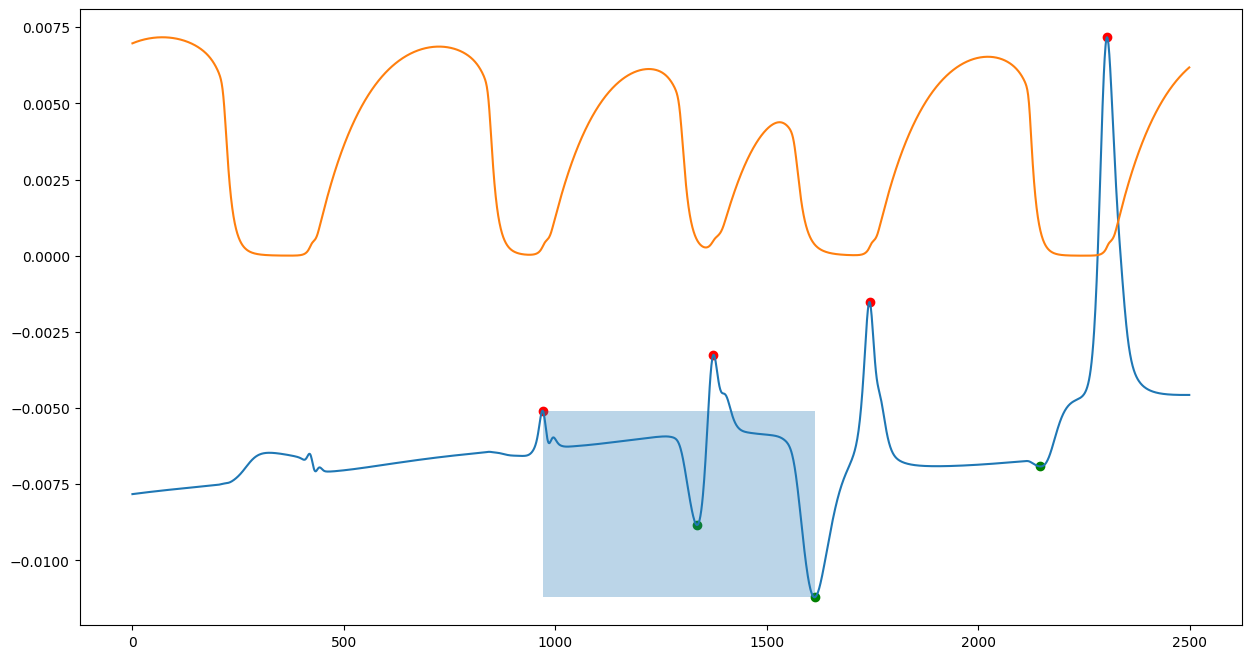

In [13]:
dA_test = dA[t_stop+500:,i,j]
T_test = T[t_stop+500:,i,j]
maxima_temp0, _ = find_peaks(dA_test,prominence=.0007)#,height=.001
minima_temp0, _ = find_peaks(-dA_test,prominence=.0007)#,height=.001
max_indx, min_indx = index_finder(maxima_temp0, minima_temp0, dA_test,start_indx=0)


plt.figure(figsize=(15,8))
plt.plot(dA_test)
plt.scatter(maxima_temp0,dA_test[maxima_temp0],c='r')
plt.scatter(minima_temp0,dA_test[minima_temp0],c='g')
plt.fill_between([maxima_temp0[max_indx],minima_temp0[min_indx+1]],dA_test[minima_temp0[min_indx+1]],dA_test[maxima_temp0[max_indx]],alpha=.3)
plt.plot(T_test/np.max(T_test)*np.max(dA_test))

t_start_fit = t_stop + 500 + maxima_temp0[max_indx] - 250
t_stop_fit = t_stop + 500+ minima_temp0[min_indx+1] + 250

print(t_start_fit,t_stop_fit)

In [ ]:
T_fit_raw = T[t_start_fit:t_stop_fit,i,j]
x_arr_fit_raw = np.array([x_temp[t_start_fit:t_stop_fit,:,i,j],x_temp[t_start_fit:t_stop_fit,:,i,j+1],x_temp[t_start_fit:t_stop_fit,:,i+1,j+1],x_temp[t_start_fit:t_stop_fit,:,i+1,j]])
dA_fit_raw = dA[t_start_fit:t_stop_fit,i,j]

number_of_comp,number_of_points,delta_t = 20,11,20

x_train,x_fit, y_train = shape_data(x_temp,x_cm_temp,dA[t_start:t_stop,:,:],T[t_start:t_stop,:,:],dA_fit_raw,i,j,number_of_comp,number_of_points,delta_t)
y_out = euclidean_distance_trajectory(x_fit, x_train,y_train)

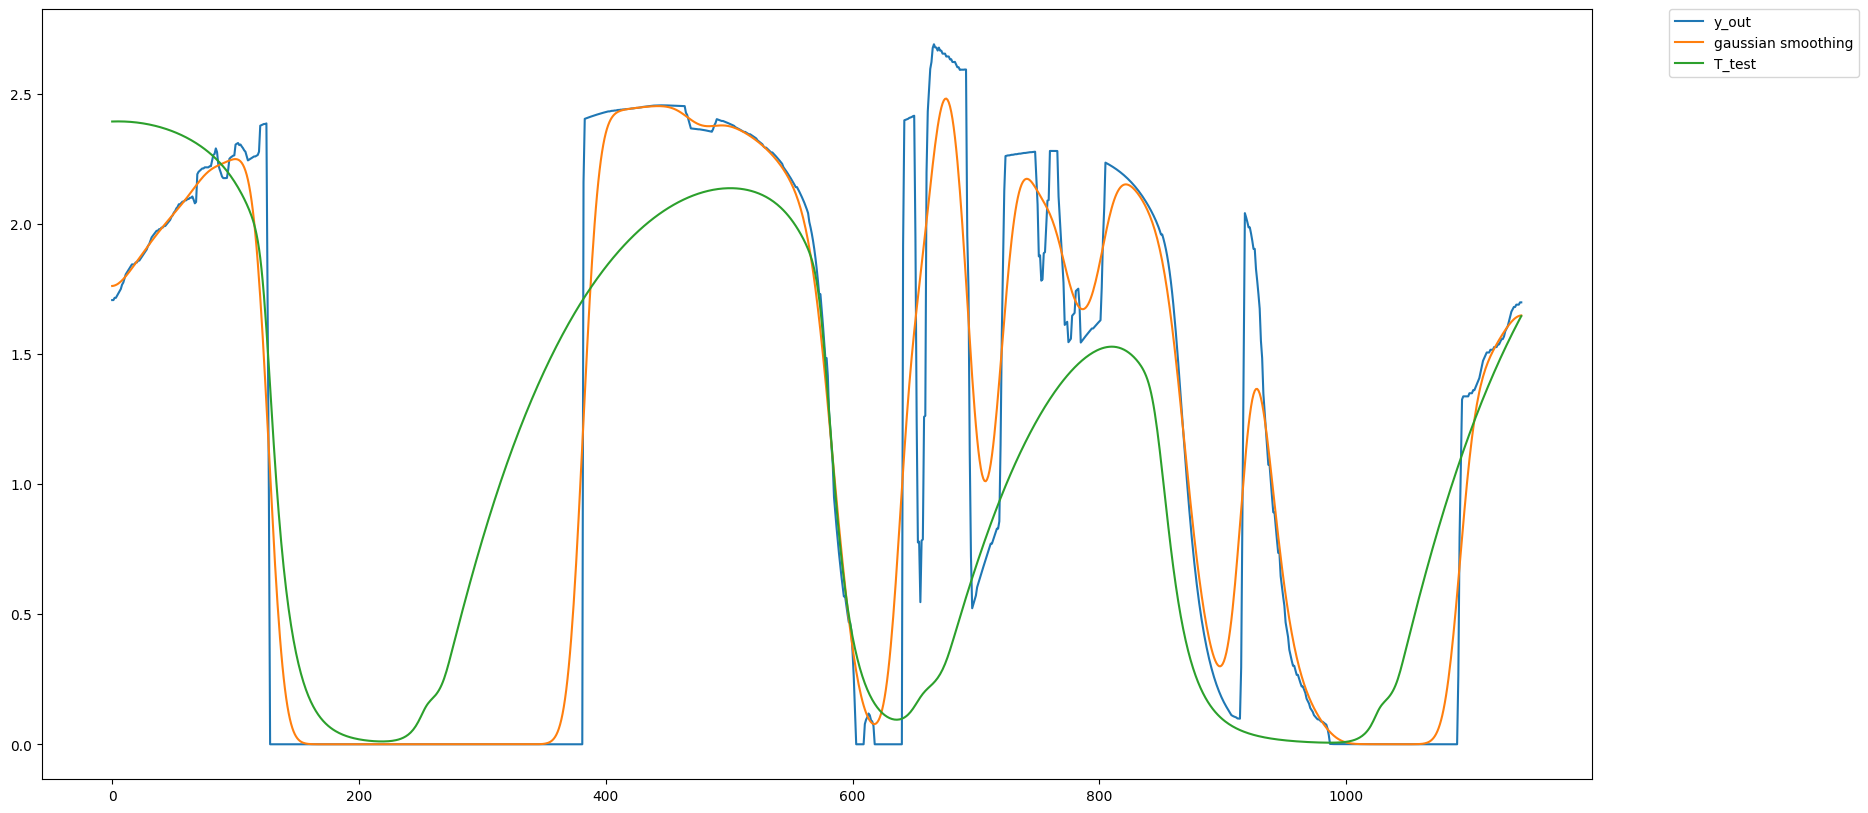

In [ ]:
T_train_smoothed = gaussian_filter1d(y_out, sigma=10)


plt.figure(figsize=(20,10))
plt.plot(y_out,label='y_out')
plt.plot(T_train_smoothed,label='gaussian smoothing')
plt.plot(T_fit_raw,label='T_test')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#plt.savefig('test.png')